# Using deep learning API to expedite implementation

__Contents:__

- <a href="#AD_bg">Background on automatic differentiation</a>
  - <a href="#AD_bg_forwardone">Forward accumulation (univariate example)</a>
  - <a href="#AD_bg_forwardmulti">Forward accumulation (multi-variate example)</a>
  - <a href="#AD_bg_reverse">Reverse accumulation</a>
- <a href="#NN_bg">Neural networks and back-propagation</a>
- <a href="#chainer_bg">Getting started with Chainer</a>
  - <a href="#chainer_exSimple">A simple example</a>
  - <a href="#chainer_linreg">Re-creating least-squares linear regression</a>
  - <a href="#chainer_exNonLin">Non-linear example: gradients under arbitrary activation functions</a>
  - <a href="#chainer_lgstreg">Comparison for multi-class logistic regression</a>
  - <a href="#chainer_newopt">Doing optimization by hand</a>

___

<a id="AD_bg"></a>
## Background on automatic differentiation

In a word, automatic differentiation (AD) is computation of
composite function derivatives using multiple applications of the
chain rule. Some key points:

- Derivatives are computed analytically, "by hand".
- Depending on problem parameters, gradient "accumulation" can be done in either the forward or reverse directions.

Since exact (partial) derivative computations are done, AD is different from symbolic differentiation, and it does not use finite-difference approximations.

<a id="AD_bg_forwardone"></a>
### Forward accumulation (univariate example):

First, an example in one variable to illustrate the forward accumulation approach.

Consider a function $f(g(h(x)))$.

Let $f,g,h$ be differentiable on $\mathbb{R}$, with real-valued outputs.

Goal: differentiate $f(g(h(x)))$ with respect to $x$.

Represent as follows:

\begin{align*}
u_{0} & = x\\
u_{1} & = h(u_{0})\\
u_{2} & = g(u_{1})\\
u_{3} & = f(u_{2}).
\end{align*}

Note that

\begin{align*}
\frac{d u_{3}}{d x} & = \left(\frac{d u_{3}}{d u_{2}}\frac{d u_{2}}{d x}\right)\\
& = \frac{d u_{3}}{d u_{2}}\left(\frac{d u_{2}}{d u_{1}}\frac{d u_{1}}{d x}\right)\\
& = \frac{d u_{3}}{d u_{2}}\frac{d u_{2}}{d u_{1}} \left(\frac{d u_{1}}{d u_{0}}\frac{d u_{0}}{d x}\right).
\end{align*}

Focusing on the terms in parentheses, if we define

\begin{align*}
\dot{u}_{i} = \frac{d u_{i}}{d x}, \quad i = 0,1,\ldots,3
\end{align*}

it is clear that the following recursive relation holds:

\begin{align*}
\dot{u}_{i} = \frac{d u_{i}}{d u_{i-1}} \dot{u}_{i-1}.
\end{align*}

The forward accumulation procedure:


0. Compute "seed" $\dot{u}_{0}$ (typically $\dot{u}_{0}=1$).
0. For $i=1,2,\ldots$ do:
 0. Compute $d u_{i} / d u_{i-1}$.
 0. Using $\dot{u}_{i-1}$, compute $\dot{u}_{i}$.


In a finite number of steps, we arrive at $d f(g(h(x))) / dx$.

<a id="AD_bg_forwardmulti"></a>
### Forward accumulation (multi-variate example):

Next, the multi-variate setting:

\begin{align*}
\mathbf{x} \in \mathbb{R}^{d_{0}}, \enspace h:\mathbb{R}^{d_{0}} \to \mathbb{R}^{d_{1}}, \enspace g:\mathbb{R}^{d_{1}} \to \mathbb{R}^{d_{2}}, \enspace f:\mathbb{R}^{d_{2}} \to \mathbb{R}^{d_{3}}\end{align*}

Represent the key steps as

\begin{align*}
\mathbf{u}_{0} & = \mathbf{x}\\
\mathbf{u}_{1} & = h(\mathbf{u}_{0})\\
\mathbf{u}_{2} & = g(\mathbf{u}_{1})\\
\mathbf{u}_{3} & = f(\mathbf{u}_{2}).
\end{align*}

Now we work with Jacobian matrices of *partial* derivatives.

Writing $\mathbf{x} = (x_{1},\ldots,x_{d_{0}})$, $\mathbf{u}_{i}=(u_{i,1},\ldots,u_{i,d_{i}})$, the desired quantity at each step is

\begin{align*}
\dot{U}_{i} = \left[ \frac{\partial u_{i,j}}{\partial x_{k}} \right]_{j,k},
\end{align*}

a $(d_{i} \times d_{0})$ Jacobian matrix.

The key recursion is easily extended as

\begin{align*}
\frac{\partial u_{i,j}}{\partial x_{k}} = \sum_{l=1}^{d_{i-1}} \frac{\partial u_{i,j}}{\partial u_{i-1,l}} \frac{\partial u_{i-1,l}}{\partial x_{k}}
\end{align*}

for each $i=1,2\ldots$ and $j \in [d_{i}]$.

In particular, via the $(d_{i} \times d_{i-1})$ Jacobian

\begin{align*}
J_{i} = \left[\frac{\partial u_{i,j}}{\partial u_{i-1,k}}\right]_{j,k},
\end{align*}

we get a nice matrix-form recursion as

\begin{align*}
\dot{U}_{i} = J_{i}\dot{U}_{i-1}.
\end{align*}

Using seed $\dot{U}_{0}$ (typically identity matrix), the procedure runs just as the univariate case.

__Exercises:__

0. Try expanding the following functions into "layers" as above.

\begin{align*}
f(x_{1},x_{2}) & = x_{1}x_{2} + \sin(x_{1})\\
f(x_{1},x_{2}) & = x_{1}+x_{2} + 2\exp(x_{1}x_{2})\\
f(x_{1},x_{2}) & = \frac{x_{1}^{3}}{x_{2}} + \exp(\sin(x_{1}))
\end{align*}

<a id="AD_bg_reverse"></a>
### Reverse accumulation:

Now let's look at the "reverse" mode. This is perhaps somewhat less intuitive, and is more challenging to implement, but is computationally superior in many situations.

Starting with the same $y = f(g(h(x)))$ example, note

\begin{align*}
\frac{d y}{d x} & = \left(\frac{d y}{d u_{0}} \frac{d u_{0}}{d x}\right)\\
& = \left(\frac{d y}{d u_{1}} \frac{d u_{1}}{d u_{0}}\right) \frac{d u_{0}}{d x}\\
& = \left(\frac{d y}{d u_{2}} \frac{d u_{2}}{d u_{1}}\right) \frac{d u_{1}}{d u_{0}} \frac{d u_{0}}{d x}\\
& = \left(\frac{d y}{d u_{3}} \frac{d u_{3}}{d u_{2}}\right) \frac{d u_{2}}{d u_{1}} \frac{d u_{1}}{d u_{0}} \frac{d u_{0}}{d x}.
\end{align*}

Again focusing on the terms in parentheses, set

\begin{align*}
\bar{u}_{i} = \frac{d y}{d u_{i}}, \quad i=0,1,2,3.
\end{align*}

Now the recursion of interest is

\begin{align*}
\bar{u}_{i} = \bar{u}_{i+1} \frac{d u_{i+1}}{d u_{i}}.
\end{align*}

If $K$ is our highest unit, the general reverse accumulation procedure is:


0. Compute "seed" $\bar{u}_{K}$ (typically $\bar{u}_{K}=1$).
0. For $i=0,1,\ldots,K-1$ do:
 0. Compute $d u_{K-i} / d u_{K-i-1}$.
 0. Using $\bar{u}_{K-i}$, compute $\bar{u}_{K-i-1}$.

Note how we start at the highest $u_{i}$ and "descend".

For the multi-variate case, with say $\mathbf{y} = \mathbf{u}_{K}$,, we have

\begin{align*}
\frac{\partial y_{j}}{\partial u_{i,k}} = \sum_{l=1}^{d_{i+1}} \frac{\partial y_{j}}{\partial u_{i+1,l}} \frac{\partial u_{i+1,l}}{\partial u_{i,k}}
\end{align*}

for each $i=0,1,\ldots,K-1$ and $k \in [d_{i}]$.

Define matrices as:

\begin{align*}
\bar{U}_{i} & = \left[ \frac{\partial y_{j}}{\partial u_{i,k}} \right]_{j,k} \quad (d_{K} \times d_{i}), \quad i = 0,1,\ldots,K \\
\widetilde{J}_{i} & = \left[ \frac{\partial u_{i+1,j}}{\partial u_{i,k}} \right]_{j,k} \quad (d_{i+1} \times d_{i}), \quad i=0,1,\ldots,K-1.
\end{align*}

Then set seed of $\bar{U}_{K}$ (typically identity matrix), and descend with

\begin{align*}
\bar{U}_{i} = \bar{U}_{i+1} \widetilde{J}_{i}.
\end{align*}

In most cases, $d_{K}=1$ (minimizing real-valued losses):

<img src="img/mtx_mult_fromleft.png"  alt="Matrix multiplication from left" width="243"  height="250" />

Can be much faster than forward accumulation when $d_{K} \ll d_{0}$.

___

<a id="NN_bg"></a>
## Neural networks and back-propagation

A traditional neural network model is formulated by two relations:

\begin{align*}
x_{j} & = \sum_{i \to j} w_{ij}y_{i}\\
y_{j} & = f_{j}(x_{j})
\end{align*}

defined for all $j \in \mathcal{V}$, the unit index.

- $x_{j}$ is the input to unit $j$.
- $y_{j}$ is the output of unit $j$.
- $f_{j}$ is the activation function of unit $j$.
- "$i \to j$" means all $i$ such that unit $i$ feeds unit $j$.

Let $e_{i,j}$ be the indicator of "unit $i$ feeds unit $j$".

The notion of "layers" is simply subsets of units:

\begin{align*}
V_{1}, V_{2}, \ldots, V_{L} \subseteq \mathcal{V}.
\end{align*}

A *feed-forward* neural network: for any $i \in V_{l}$, $j \in V_{m}$,

\begin{align*}
m \geq l \implies e_{j,i} = 0.
\end{align*}

- In general, says nothing about $e_{i,j}$.

- Layer $l$ is "fully connected" if for all $i \in V_{l}$ and $j \in V_{l+1}$, have $e_{i,j}=1$.

- If $m > l+1$, then $e_{i,j}=1$ is a "skip-layer" connection.

- Call $j$ an *input unit* if $e_{i,j}=0$ for all $i$. Not fed by anything.

- Call $j$ an *output unit* if $e_{j,i}=0$ for all $i$. Doesn't feed anything.


Some typical activation functions:

- Linear: $f(x) = x$
- Threshold: $f(x) = I\{x > 0\}$
- Logistic: $f(x) = e^{x}/(1+e^{x})$
- Rectified linear unit: $f(x) = \max\{0,x\}$

To optimize the weights, we typically introduce an objective $L$, which almost always depends directly on the output units; denote the output layer by $O \subset \mathcal{V}$. For regression tasks, perhaps the simplest and most common choice of loss functions is the $\ell_{2}$ error

\begin{align*}
L = \sum_{l \in O} (t_{l} - y_{l})^{2},
\end{align*}

where the $t_{l}$ are elements of the output vector to be predicted. A now-standard approach is to use some form of first-order steepest descent,

\begin{align*}
w_{ij} \gets w_{ij} - \eta \frac{\partial L}{\partial w_{ij}}.
\end{align*}

For $w_{ij}$, noting the importance of $j$, dependence unfolds as

\begin{align*}
L & = L((y_{l})_{l \in O})\\
y_{l} & = f_{l}(x_{l})\\
x_{l} & = x_{l}(y_{j})\\
y_{j} & = f_{j}(x_{j})
\end{align*}

Of course, the dependence of unit $l$ on unit $j$ may be trivial in the sense that there is no dependence at all. Non-trivial cases are of interest: unit $j$ itself, the units that $j$ feeds, and all units that those units feed, and so on.

Application of the chain rule leads to convenient expressions. Assuming the activations are all differentiable, we have

\begin{align*}
\frac{\partial L}{\partial w_{ij}} & = \sum_{l \in O} \frac{\partial L}{\partial y_{l}} \frac{\partial y_{l}}{\partial y_{j}} \frac{\partial y_{j}}{\partial x_{j}} \frac{\partial x_{j}}{\partial w_{ij}}\\
& = y_{i} f_{j}^{\prime}(x_{j}) \sum_{l \in O} \frac{\partial L}{\partial y_{l}} \frac{\partial y_{l}}{\partial y_{j}}\\
& = y_{i} f_{j}^{\prime}(x_{j}) \frac{\partial L}{\partial y_{j}}.
\end{align*}

Writing $\delta_{j} = f_{j}^{\prime}(x_{j}) (\partial L / \partial y_{j})$, this is

\begin{align*}
\frac{\partial L}{\partial w_{ij}} = y_{i} \delta_{j}.
\end{align*}

This is the "generalized delta rule" popularized by Rumelhart and McClelland in the mid-1980s.

In order to do this efficiently, we can "back-propagate" the errors, as follows. First, note that for any $l \in O$, the $\delta_{l}$ is directly computable based on $L$. For example, under the squared error,

\begin{align*}
\delta_{l} & = 2y_{l}(1 - y_{l})(y_{l} - t_{l}), & \text{ logistic activations}\\
\delta_{l} & = 2(y_{l} - t_{l}), & \text{ linear activations}
\end{align*}

and so forth depending on the choice of activation function. For $l \notin O$, express the impact of $y_{l}$ on $L$ via the outputs of units $l$ feeds, namely

\begin{align*}
\frac{\partial L}{\partial y_{l}} & = \sum_{i:l \to i} \frac{\partial L}{\partial y_{i}} \frac{\partial y_{i}}{\partial y_{l}}\\
& = \sum_{i:l \to i} \frac{\partial L}{\partial y_{i}} f_{i}^{\prime}(x_{i}) w_{li}.
\end{align*}

Cleaning up, we have

\begin{align*}
\delta_{l} = f_{l}^{\prime}(x_{l}) \sum_{i:l \to i} \delta_{i} w_{li}.
\end{align*}

In words: for any $\delta_{l}$, if we have already computed $\delta_{i}$ for all units such that $l \to i$, then we can compute $\delta_{l}$. We start at the outermost layer, and work "backwards". This is back-propagation. A note on terminology: starting from the input units and computing all the $y_{j}$ is often called a *forward pass*, in contrast with computation of all the deltas and such required to get partial derivatives, called a *backward pass* over the network.

How does this all connect with reverse-mode AD? Back-propagation of errors in order to compute the gradient of a real-valued loss with respect to a large number of parameters is a special case of reverse-mode AD.

The connection to the generalized delta rule is most easily understood using a concrete example. Consider the simple feed-forward network below.

<img src="img/nn_demo.png"  alt="Hand-drawn NN example" width="350" height="245" />

Unit indices as drawn: $1,2,3,4,5,6$. Inputs encoded as $u_{1},u_{2},u_{3}$. The rest as follows:

\begin{align*}
u_{4} & = x_{4} = \sum_{i \to 4} w_{i4}u_{i}\\
u_{5} & = x_{5} = \sum_{i \to 5} w_{i5}u_{i}\\
u_{6} & = y_{4} = f_{4}(x_{4})\\
u_{7} & = y_{5} = f_{5}(x_{5})\\
u_{8} & = x_{6} = \sum_{i \to 5} w_{i6}u_{i}\\
u_{9} & = y_{6} = f_{6}(x_{6})
\end{align*}

Relevant deltas are 

\begin{align*}
\delta_{4} = \frac{\partial u_{9}}{\partial u_{4}}, \quad \delta_{5} = \frac{\partial u_{9}}{\partial u_{5}}, \quad \delta_{6} = \frac{\partial u_{9}}{\partial u_{8}}
\end{align*}

which are all naturally captured as part of the reverse-mode AD procedure outlined above.

___

<a id="chainer_bg"></a>
## Getting started with Chainer

Having covered automatic differentiation and neural networks, a clear strategy is available for efficient computation of gradients. That said, implementing this in practice for a wide variety of neural network architectures requires a tremendous amount of effort. Fortunately, many open-source Python libraries exist, providing a user-friendly API for prototyping machine learning systems involving neural network models.

We elect to use __Chainer__, from the Japan-based Preferred Networks [<a href="https://docs.chainer.org/en/stable/">link</a>]. While alternatives such as TensorFlow, PyTorch, and Caffe are more well-known, Chainer is *extremely* easy to use, has a very elegant design, and the flexibility to handle all manner of models and learning algorithms included in other libraries. It also comes with support for multi-GPU hardware setups to take advantage of GPU-based acceleration. The core concept driving Chainer is a "Define-by-Run" strategy, in which the network is defined dynamically during forward pass computations [<a href="https://docs.chainer.org/en/stable/guides/define_by_run.html">link</a>].


Regarding installation: we assume that `chainer` has already been installed on your system via `pip`, as is recommended in their documentation [<a href="https://docs.chainer.org/en/stable/install.html">link</a>].

Some important general points regarding model construction:

- Virtually all data and parameters (i.e., anything stored in a Numpy array) will be cast as `Variable` objects [<a href="https://docs.chainer.org/en/stable/guides/variables.html">link</a>].

- `Variable` objects can be treated almost the same as Numpy arrays [<a href="https://docs.chainer.org/en/stable/reference/generated/chainer.Variable.html#chainer.Variable">link</a>].

- `FunctionNode` objects represent nodes in a computational graph, and they are implementations of *differentiable functions* applied to node inputs [<a href="https://docs.chainer.org/en/stable/reference/generated/chainer.FunctionNode.html#chainer-functionnode">link</a>].

- For each `FunctionNode`, we implement `forward()` and `backward()` methods, corresponding to forward and backward passes over the network.

- Given inputs, a `FunctionNode` object is executed using the `apply()` method, which helps construct the computational graph, and returns the output arrays of a forward pass.

- `Link` objects are the building blocks of models in Chainer [<a href="https://docs.chainer.org/en/stable/reference/generated/chainer.Link.html#chainer.Link">link</a>]. A `Link` based on a `FunctionNode` specifies which of the `Variable` objects are inputs, and which should be "registered" as `Parameter` objects for training, a *critical* distinction. `Link`s also `__call__()` the `FunctionNode`s upon which they are based.

- `Chain` objects are basically compositions of `Link`s, and they can be used to represent the entire model, or just a subset, since `Chain`s are also `Link`s [<a href="https://docs.chainer.org/en/stable/reference/generated/chainer.Chain.html#chainer-chain">link</a>]. Each `Chain` is composed of "child links" which are registered to it.

While a bit over-simplified, the key steps of the training process are as follows:

- Model objects (`Chain` sub-classes) are passed to `Optimizer` objects (prior to iteration) via `setup()` method.

- Iteratively, do the following:

  - Compute a real-valued `Variable`, let's call it `loss`.
  
  - Run `loss.backward()` to run back-propagation, starting from this `Variable` and going all the way back down the graph to all relevant `FunctionNode` objects.
  
  - With gradients in hand for the current step, use `Optimizer` to `update()` the `Parameter`s of interest in our model.



<a id="chainer_exSimple"></a>
### A simple example

Let's try some simple practice exercises to make sure we know how computations are done:

\begin{align*}
y = 2 x_{1}x_{2} + e^{x_{1}}
\end{align*}

In [1]:
import math
import chainer as ch
import numpy as np

In [2]:
touse_1 = 1.5
touse_2 = 3.0

x1 = ch.Variable(np.array([touse_1], dtype=np.float32))
x2 = ch.Variable(np.array([touse_2], dtype=np.float32))
y = 2*x1*x2 + math.exp(1)**x1

# Note that all gradients start out empty.
print("Gradients prior to calling y.backward():")
print(y.grad)
print(x1.grad)
print(x2.grad)

# Now, compute the gradients of y.
y.backward()
print("\nGradients after calling y.backward():")
print(y.grad)
print(x1.grad, "( answer =",
      np.float32(2*x2.data[0] + math.exp(1)**x1.data[0]),
      ")")
print(x2.grad, "( answer =",
      np.float32(2*x1.data[0] + 0),
      ")")

Gradients prior to calling y.backward():
None
None
None

Gradients after calling y.backward():
[1.]
[10.481689] ( answer = 10.481689 )
[3.] ( answer = 3.0 )


So, it does get the right answer. To see how this computation is actually done, let's re-formuate this into three "layers", $\mathbf{u}_{0}, \mathbf{u}_{1}, \mathbf{u}_{2}$, where

\begin{align*}
\mathbf{u}_{0} & = (u_{0,1}, u_{0,2}) = (x_{1}, x_{2})\\
\mathbf{u}_{1} & = (u_{1,1}, u_{1,2}) = (u_{0,1}u_{0,2}, e^{u_{0,1}})\\
\mathbf{u}_{2} & = (u_{2,1}) = (2u_{1,1} + u_{1,2}).
\end{align*}

We start with $\mathbf{u}_{0}$, and do two transformations, $\mathbf{u}_{0} \mapsto \mathbf{u}_{1} \mapsto \mathbf{u}_{2}$. Below, we implement these two transformations as `U1` and `U2`, which are `FunctionNode` sub-classes.

In [3]:
class U1(ch.function_node.FunctionNode):
    
    def forward(self, inputs):
        
        u0, = inputs
        u1 = np.array([u0[0,0]*u0[0,1], math.exp(1)**u0[0,0]],
                      dtype=np.float32)
        u1 = u1.reshape((1,2))
        self.retain_inputs((0,))
        return (u1,)

    def backward(self, indices, grad_outputs):
        
        u0, = self.get_retained_inputs()
        u0 = u0.data
        gy, = grad_outputs # defaults to shape (1,2).
        print("U1 gy:", gy.data)
        
        # Compute the Jacobian.
        J = np.array([u0[0,1], u0[0,0], math.exp(1)**u0[0,0], 0.0],
                     dtype=np.float32).reshape((2,2))
        J = ch.Variable(J)
        
        # Compute partial derivatives of interest.
        gu0 = gy @ J # gy.dot(J)
        print("U1 backward():", gu0.data)
        return (gu0,)

def fn_u1(u0):
    args = (u0,)
    y, = U1().apply(args)
    return y


class U2(ch.function_node.FunctionNode):
    
    def forward(self, inputs):
        
        u1, = inputs
        u2 = np.array([2*u1[0,0]+u1[0,1]])
        self.retain_inputs((0,))
        return (u2,)

    def backward(self, indices, grad_outputs):
        
        u1, = self.get_retained_inputs()
        gy, = grad_outputs # defaults to shape (1,).
        gy = gy.reshape((1,1))
        gy = ch.functions.cast(gy, np.float32)
        print("U2 gy:", gy.data)
        
        # Compute the Jacobian.
        J = np.array([2.0, 1.0], dtype=np.float32).reshape((1,2))
        J = ch.Variable(J)
        
        # Compute partial derivatives of interest.
        gu1 = gy @ J # gy.dot(J)
        print("U2 backward():", gu1.data)
        return (gu1,)
    
def fn_u2(u1):
    args = (u1,)
    y, = U2().apply(args)
    return y

Implementing the `forward()` methods is trivial; just follow the definitions given above.

As for the `backward()` pass, from the Chainer documentation (see image below):

<img src="img/chainer_backward_out.png" alt="Chainer documentation on backward pass" width="400" height="250" />

That is, we compute the Jacobian matrices for each layer, and then sum over the output index, weighted by `grad_outputs`. In `U1`, the `J` we compute is $(2 \times 2)$, and takes the form

\begin{align*}
\left[ \frac{\partial u_{1,i}}{\partial u_{0,j}} \right]_{i,j}, \quad i = 1,2 \quad j = 1,2.
\end{align*}

For `U2`, the `J` we compute is $(1 \times 2)$, and takes the form

\begin{align*}
\left[ \frac{\partial u_{2,i}}{\partial u_{1,j}} \right]_{i,j}, \quad i = 1 \quad j = 1,2.
\end{align*}

From our understanding of reverse-mode automatic differentiation, recall the recursion

\begin{align*}
\bar{U}_{i} = \bar{U}_{i+1} \widetilde{J}_{i}
\end{align*}

with matrices (assuming $K$ layers) as

\begin{align*}
\bar{U}_{i} & = \left[ \frac{\partial y_{j}}{\partial u_{i,k}} \right]_{j,k} \quad (d_{K} \times d_{i}), \quad i = 0,1,\ldots,K \\
\widetilde{J}_{i} & = \left[ \frac{\partial u_{i+1,j}}{\partial u_{i,k}} \right]_{j,k} \quad (d_{i+1} \times d_{i}), \quad i=0,1,\ldots,K-1.
\end{align*}

In this special case, $K=2$, and dimensions are $d_{0}=2, d_{1}=2, d_{2}=1$. Let us observe below that running `backward()` on the output of our custom nodes indeed perfectly mimics that of the original code.

In [4]:
touse_1 = 1.5
touse_2 = 3.0

# Original code.
x1 = ch.Variable(np.array([touse_1], dtype=np.float32))
x2 = ch.Variable(np.array([touse_2], dtype=np.float32))
y = 2*x1*x2 + math.exp(1)**x1
y = y.reshape((1,1))

# Our custom reformulation.
_u0 = np.array([touse_1, touse_2], dtype=np.float32).reshape((1,2))
_u0 = ch.Variable(_u0)
_u1 = fn_u1(u0=_u0)
_y = fn_u2(u1=_u1)
_y = _y.reshape((1,1))

print("Output of forward passes:")
print("y:", *y.data[0])
print("_y:", *_y.data[0])

y.backward()
print("\nContent of our backward() passes:")
_y.backward()

print("\nGradient of (x1,x2):", (x1.grad[0], x2.grad[0]))
print("Gradient of u0:", tuple(*_u0.grad))

Output of forward passes:
y: 13.481689
_y: 13.481688976287842

Content of our backward() passes:
U2 gy: [[1.]]
U2 backward(): [[2. 1.]]
U1 gy: [[2. 1.]]
U1 backward(): [[10.481689  3.      ]]

Gradient of (x1,x2): (10.481689, 3.0)
Gradient of u0: (10.481689, 3.0)


From the above, note how the output of `backward()` in layer two is passed to layer one via `grad_outputs`. This is exactly as we would expect.

__One critical point:__ for general automatic differentiation frameworks, the final output can be $\bar{U}_{0}$ of shape ($d_{K} \times d_{0}$), in Chainer, this is *always* restricted to $d_{K}=1$. That this is *true* is obvious: from the documentation, when implementing `backward()` for a function $f: \mathbb{R}^{a} \to \mathbb{R}^{b}$, the output must belong to $\mathbb{R}^{a}$. Mathematically, what does this mean? Well, in our previous example, say we ran backprop (still WRT $\mathbf{u}_{0}$) on $\mathbf{u}_{1} \in \mathbb{R}^{2}$, instead of $\mathbf{u}_{2} \in \mathbb{R}$. In order to do this, we need to provide `grad_outputs` ourselves by initializing the gradients, as in the code block below.

In [5]:
_u0 = np.array([touse_1, touse_2], dtype=np.float32).reshape((1,2))
_u0 = ch.Variable(_u0)
_u1, = fn_u1(u0=_u0)
_u1.grad = np.ones(_u1.shape, dtype=np.float32)
_u1.backward()
print("_u0.grad =", tuple(*_u0.grad))

U1 gy: [[1. 1.]]
U1 backward(): [[7.481689 1.5     ]]
_u0.grad = (7.481689, 1.5)


Note that the result changes, since the multiplication by two in the last transformation is not reflected when we stop early. Now, one might intuitively expect that in this case the final output of automated differentiation stored in `_u0.grad` would be the Jacobian matrix $\partial \mathbf{u}_{1} / \partial \mathbf{u}_{0}$, but clearly this can never happen. It only stores gradient vectors. Then the question is: mathematically, what function is being differentiated? Chainer, just like other popular APIs with back-propagation, actually is differentiating a real-valued dummy function of the form

\begin{align*}
f(\mathbf{u}_{K}) = a_{1} u_{K,1} + \cdots + a_{K} u_{K,d_{K}}
\end{align*}

where $\mathbf{u}_{K}$ is the output of our final layer of variables, and $(a_{1},\ldots,a_{K})$ correspond to the very first `grad_outputs` used in back propagation. In the example above where we set

```
_u1.grad = np.ones(_u1.shape, dtype=np.float32)
```

this is nothing more than using a dummy function with $a_{1}=\cdots=a_{K}=1$.

To summarize, if the final output is real-valued, then everything is exactly as we expect, because $d_{K}=1$. If on the other hand, we have $d_{K} > 1$, our initialization of the `grad` attribute of the output layer of variables will determine which dummy function is used in the background (`grad` is initialized to 1 by default in the $d_{K}=1$ case).

__Exercises:__

0. In the example above where we stopped at the second layer (and initialized the `grad` attribute to all ones), how could we have initialized `_u1.grad` such that calling `_u1.backward()` has the same effect as calling `_u2.backward()` (as we did to begin with)?

0. Extend the above example by adding more transformations, such that it naturally has three or four "layers". Implement it yourself just as above, and confirm that Chainer behaves the way we expect.


<a id="chainer_linreg"></a>
### Re-creating least-squares linear regression

Recall from a <a href="FrameworkIntro.ipynb">previous notebook</a> that as a simple practice system, we developed the following:

> - Data: Inputs and responses, $x \in \mathbb{R}^{d}$, $y \in \mathbb{R}$. Data set is $\{(x_{1},y_{1}),\ldots,(x_{n},y_{n})\}$.
> 
> - Model: Linear regression, with squared error. Assume $y = \langle w^{\ast}, x\rangle + \varepsilon$ as underlying model. Loss is $L(w;x,y) = (y - \langle w, x\rangle)^{2}/2$, with gradient $\nabla L(w;x,y) = -(y-\langle w, x\rangle)x$.
> 
> - Algorithm: steepest descent routine with step size $\alpha > 0$. Writing $z_{i}=(x_{i},y_{i})$, this is
> 
> \begin{align*}
w_{(t+1)} \gets w_{(t)} - \alpha \frac{1}{n} \sum_{i=1}^{n}\nabla L(w_{(t)}; z_{i}).
\end{align*}

All the code required for this implementation is stored in separate files `algorithms.py`, `models.py`, `dataclass.py`, and `helpers.py`.  Our goal here (as a practice exercise) is to *precisely* reproduce the output of our hand-built implementation, using a purely Chainer-based implementation.

Let's get started. First we `import` all required modules and build a `FunctionNode` object which implements a "fully connected linear layer".

In [6]:
import math
import numpy as np
import chainer as ch
import matplotlib
import matplotlib.pyplot as plt

import algorithms
import models
import dataclass
import helpers as hlp

In [7]:
# FunctionNode sub-class, for implementing a fully connected linear layer.

class LinearFunction(ch.function_node.FunctionNode):
    '''
    FunctionNode object, defined on Variable objects,
    which is the basis for a linear transformation to
    be wrapped up as a Link object.
    
    Take d-dimensional inputs x, and using array W of
    shape (k,d), map this input to k outputs. That is,
    we have a fully-connected layer with d input units
    and k output units.
    '''
    
    def forward(self, inputs):
        '''
        Forward computation for both CPU and GPU.
        '''
        
        # Unpack the tuple of inputs.
        if len(inputs) == 3:
            x, W, b = inputs
        else:
            (x, W), b = inputs, None

        y = x.dot(W.T).astype(x.dtype, copy=False)
        
        # Add a bias term, if relevant.
        if b is not None:
            y += b
            
        # Since backward() depends only on x and W,
        # we need only retain these two.
        self.retain_inputs((0,1))
        
        # Must return the output as a tuple.
        return (y,)

    def backward(self, indices, grad_outputs):
        '''
        General-purpose computation for both CPU/GPU.
        '''
        
        x, W = self.get_retained_inputs()
        gy, = grad_outputs # written as gamma in their docs.
        
        # Says that backward() must return a tuple, but
        # looking at their source code for linear.py, it
        # seems like lists are fine.
        out = []
        if 0 in indices:
            gx = gy @ W # gy.dot(W)
            out.append(ch.functions.cast(gx, x.dtype))
        if 1 in indices:
            gW = gy.T @ x # gy.T.dot(x)
            out.append(ch.functions.cast(gW, W.dtype))
        if 2 in indices:
            # Summing here is simple: for n observations,
            # gy has shape (n,k), where k is the number of
            # layer outputs. Summing over axis=0 is summing
            # over OBSERVATIONS, not over outputs.
            gb = ch.functions.sum(gy, axis=0)
            
        # Return just the relevant gradients we appended.
        return out


def linear(x, W, b):
    '''
    A nice thin wrapper for our linear FunctionNode on
    Variable objects.
    '''
    
    if b is None:
        args = (x, W)
    else:
        args = (x, W, b)
    
    # Don't forget to unpack from the tuple.
    y, = LinearFunction().apply(args)
    return y

Key points regarding this `FunctionNode` definition:

- `forward()` is defined just using arrays.
- `backward()` does summation over examples.
- Furthermore, `backward()` must handle `Variable` objects, thus the special operator notation.

In [8]:
# Link object for our linear FunctionNode.

class Linear(ch.Link):
    '''
    A Link class for our linear transformation, implemented
    in the LinearFunction class.
    '''
    def __init__(self,
                 in_size, out_size,
                 init_W=None, init_b=None,
                 init_delta=None,
                 nobias=False):
        super(Linear, self).__init__()
        
        # Here we initialize and "register" the parameters
        # of interest. This is critical because when we
        # call __call__(x) and apply the underlying affine
        # transformations to input x (both forward pass and
        # backward pass), the optimization algorithms knows
        # that we want to optimize W and maybe b, but not x.

        with self.init_scope():
            
            # If provided an ndarray, use it.
            if init_W is not None:
                self.W = ch.Parameter(initializer=np.copy(init_W))
            
            # Else, use a built-in initializer.
            else:
                W_initializer = ch.initializers.Uniform(scale=init_delta,
                                                        dtype=np.float32)
                self.W = ch.Parameter(initializer=W_initializer,
                                      shape=(out_size, in_size))
            
            if nobias:
                self.b = None
            else:
                if init_b is not None:
                    self.b = ch.Parameter(initializer=np.copy(init_b))
                else:
                    self.b = ch.Parameter(initializer=0,
                                          shape=(out_size,))
                
    def __call__(self, x):
        '''
        This method actually applies the linear layer to
        inputs x.
        '''
        return linear(x, self.W, self.b)


The most important part of this `Link` definition is that it "registers" the parameters to be trained, by using the `init_scope()` context manager, and keeps them as attributes. This `Link` is build on top of our `LinearFunction` sub-class of `FunctionNode`, and it is called by `__call__()`. Note critically that the inputs `x` are distinguished from the parameters `W` and `b` here. All of these variables are required to compute forward passes, but only the latter are parameters we want to learn!

Finally, prepare a `Chain` object, namely a model composed of `Link` objects. Note that a `Chain` has essentially the same structure as a `Link`, since it is indeed a `Link` itself.

In [9]:
# Chain object, composed of Link objects. This is a proper model in the
# sense that it can be fed to optimizers.

class Chain_LinReg(ch.Chain):
    '''
    Perhaps the simplest possible model, a
    feed-forward neural network without any
    hidden layers. Just one, fully-connected
    linear layer, aka a classical linear
    regression model, with arbitrary number
    of outputs.
    
    out_l0: number of outputs from layer 0.
    out_l1: number of outputs from layer 1.
    '''
    
    def __init__(self,
                 out_l0,
                 out_l1,
                 init_W=None,
                 init_b=None,
                 init_delta=1.0,
                 nobias=False):
        super(Chain_LinReg, self).__init__()
        
        with self.init_scope():
            self.l1 = Linear(in_size=out_l0,
                             out_size=out_l1,
                             init_W=init_W,
                             init_b=init_b,
                             init_delta=init_delta,
                             nobias=True)

    def __call__(self, x):
        return self.l1(x) # parameters are managed by Links.



Just as individual `Link` objects register parameters, individual `Chain` objects register "child links" using the `init_scope()` context manager, and keep these child links as attributes. In the above case, our model is extremely simple: we take input vectors of size `out_l0`, perform matrix multiplication via `Linear`, and return an output vector of size `out_l1`.

The *key* question of interest is whether or not differentiation works in Chainer as we expect it to. To verify this, let's run gradient descent using both models, on a common data set.

In [10]:
## Experiment setup.

# Data-related.
data = dataclass.DataSet() # Initialize one data object; will be re-populated at each trial.
n = 500 # sample size
d = 2 # number of parameters
init_delta = 5.0 # controls support of random initialization
num_trials = 250 # number of independent random trials to conduct
cov_X = np.eye(d) # covariance matrix of the inputs.

w_star = np.ones(d).reshape((d,1)) # vector specifying true model

# Algorithm-related.
m_idx_todo = [0,1] # let's us manually pick and choose which methods to evaluate.
t_max = 30 # termination condition; maximum number of iterations.
thres = -1.0 # termination condition; if negative, runs for max iterations.

def alpha_fixed(t, val): # step-size callback function.
    return val
def make_step(u):
    def mystep(t, model=None, data=None, newdir=None):
        return alpha_fixed(t=t, val=u)
    return mystep
alphaval = 0.25

# Clerical.
mth_names = ["gd", "gd-ch"]
num_mths = len(mth_names)
mth_colours = ["black", "blue"]

In [11]:
# Make choice of additive noise distribution (un-comment your choice).
#paras = {"name": "norm", "shift": 0.0, "scale": 20.0}
paras = {"name": "lnorm", "meanlog": 0.0, "sdlog": 1.75}

# Put together risk function.
def risk(w):
    mean_noise, var_noise = hlp.noise_risk(paras=paras)
    return hlp.riskMaker(w=w, A=cov_X, b=math.sqrt(var_noise), w_star=w_star)
risk_star = risk(w=w_star) # optimal risk value.

In [17]:
## Running the algorithms.

# Prepare storage for performance metrics.
riskvals = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
loss_tr = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
truedist = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)

# Loop over trials.
for tri in range(num_trials):
    
    # Generate new data (with *centered* noise).
    X = np.random.normal(loc=0.0, scale=1.0, size=(n,d))
    noise = hlp.noise_data(n=n, paras=paras)
    y = np.dot(X, w_star) + noise
    data.init_tr(X=X, y=y)
    
    # Data for Chainer model.
    Z = ch.datasets.TupleDataset(np.float32(X),
                                 np.float32(y))
    
    # Initial weight settings.
    w_init = w_star + np.random.uniform(low=-init_delta, high=init_delta, size=d).reshape((d,1))
    w_init = np.float32(w_init)
    
    # Initialize models (hand-built).
    mod_learner = models.LinearL2(data=data)
    risk_star = risk(w=w_star) # optimal risk value.
    loss_star = np.mean(mod_learner.l_tr(w=w_star, data=data))
    
    # Initialize models (Chainer-based).
    mod_chainer = Chain_LinReg(out_l0=d,
                               out_l1=1,
                               init_W=w_init.T,
                               init_b=None,
                               init_delta=init_delta,
                               nobias=True)
    
    # Initialize algorithms (hand-built).
    al_gd = algorithms.Algo_GD(w_init=w_init,
                               step=make_step(alphaval),
                               t_max=t_max,
                               thres=thres,
                               store=True,
                               lamreg=None)
    
    # Initialize algorithms (Chainer-based).
    opt_chainer = ch.optimizers.SGD(lr=alphaval)
    opt_chainer.setup(mod_chainer) # pass model!

    
    # Run all algorithms and save their performance.
    
    ## ERM-GD.
    mthidx = 0
    if mthidx in m_idx_todo:        
        idx = 0
        for onestep in al_gd:
            al_gd.update(model=mod_learner, data=data)
            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod_learner.l_tr(w=al_gd.w, data=data))-loss_star
            riskvals[tri,idx,mthidx] = risk(w=al_gd.w)-risk_star
            truedist[tri,idx,mthidx] = np.linalg.norm(w_star-al_gd.w)-0
            idx += 1
        
        
    ## Replication of ERM using Chainer.
    mthidx = 1
    if mthidx in m_idx_todo:
        idx = 0
        iter_train = ch.iterators.SerialIterator(dataset=Z,
                                                 batch_size=n, # thus SGD=GD; deterministic.
                                                 repeat=True,
                                                 shuffle=False)
        while iter_train.epoch < t_max:

            # Get our mini-batch.
            Z_batch = iter_train.next()
            X_batch, y_batch = ch.dataset.concat_examples(Z_batch)

            # Predictions.
            prediction_tr = mod_chainer(X_batch)

            # Loss computations (will feed the grad computations).
            loss = ch.functions.mean_squared_error(prediction_tr, y_batch) / 2.0
            #old_loss = np.mean(mod_learner.l_tr(w=mod_chainer.l1.W.data.T, data=data))
            #print("old versus new:")
            #print(loss, old_loss)
            loss_star = np.mean(mod_learner.l_tr(w=w_star, data=data))
            
            # Gradient computations.
            mod_chainer.cleargrads()
            loss.grad = np.ones(loss.data.shape, dtype=np.float32)
            loss.backward()

            # Parameter updates.
            opt_chainer.update()

            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod_learner.l_tr(w=mod_chainer.l1.W.data.T, data=data))-loss_star
            riskvals[tri,idx,mthidx] = risk(w=mod_chainer.l1.W.data.T)-risk_star
            truedist[tri,idx,mthidx] = np.linalg.norm(w_star-mod_chainer.l1.W.data.T)-0
            idx += 1


# Finally, take statistics of the performance metrics over all trials.
ave_loss_tr = np.mean(loss_tr, axis=0)
ave_riskvals = np.mean(riskvals, axis=0)
ave_truedist = np.mean(truedist, axis=0)
sd_loss_tr = np.std(loss_tr, axis=0)
sd_riskvals = np.std(riskvals, axis=0)
sd_truedist = np.std(truedist, axis=0)

Description of key points:

- Note that setting `loss.grads` to union manually is not necessary here, because it is done automatically on the back end when the `Variable` is a scalar.

- We must call the `cleargrads()` method of the model object (`mod_chainer`, a `Chain` of course) so that gradients are not accumulated across iterations.

- The `Optimizer` object (here, `opt_chainer`) handles parameter updates. Since the controllable `Parameter` objects are registered to `mod_chainer`, and `mod_chainer` is passed to `opt_chainer`, it has all the info it needs.

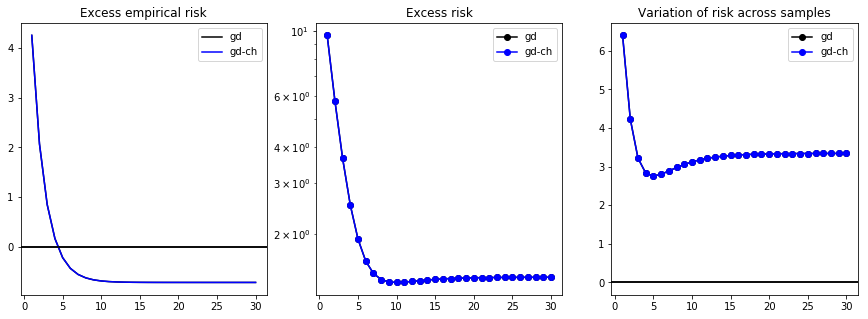

In [10]:
## Visualization of performance.

tvals = np.arange(t_max)+1 # better to start from the first update.

# Average over trials.
myfig = plt.figure(figsize=(15,5))

ax_loss_tr = myfig.add_subplot(1, 3, 1)
for m in m_idx_todo:
    vals = ave_loss_tr[:,m]
    err = sd_loss_tr[:,m]
    ax_loss_tr.plot(tvals, vals, color=mth_colours[m], label=mth_names[m])
    #ax_loss_tr.errorbar(tvals, vals, yerr=err, fmt='-o', col=mth_colours[m], label=mth_names[m])
    ax_loss_tr.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Excess empirical risk")

ax_riskvals = myfig.add_subplot(1, 3, 2)
for m in m_idx_todo:
    vals = ave_riskvals[:,m]
    err = sd_riskvals[:,m]
    err_log = err / vals
    ax_riskvals.semilogy(tvals, vals, "-o", color=mth_colours[m], label=mth_names[m])
    ax_riskvals.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Excess risk")

ax_variation = myfig.add_subplot(1, 3, 3)
for m in m_idx_todo:
    vals = sd_riskvals[:,m]
    ax_variation.plot(tvals, vals, "-o", color=mth_colours[m], label=mth_names[m])
    ax_variation.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Variation of risk across samples")


plt.show()

__Exercises:__

0. We are using `iter_train.epoch` in our termination condition: what does an "epoch" mean in Chainer here? Note how the behaviour changes when we change the mini-batch size from $n$ to something smaller than $n$.

<a id="chainer_exNonLin"></a>
### Non-linear example: gradients under arbitrary activation functions

Continuing in the same fashion, let's make a *simple* extension from a linear layer to a non-linear layer. Given inputs $\mathbf{x} \in \mathbb{R}^{d_{0}}$, map to $\mathbf{y} = (y_{1},\ldots,y_{d_{1}})$, defined as follows:

- Linear: $y_{j} = \mathbf{w}_{j}^{T}\mathbf{x} + b_{j}$

- Non-linear: $y_{j} = \phi(\mathbf{w}_{j}^{T}\mathbf{x} + b_{j})$

Now, in the `backward()` method of any `FunctionNode` object that implements the above transformations, we must compute the Jacobian $\partial \mathbf{y} / \partial \mathbf{w}$ (let us say it is $d_{1} \times d_{0}$), and matrix multiply with `grad_outputs`, which is $1 \times d_{1}$. The Jacobian matrix is easy to compute, since partial derivatives are computed in the linear case as

\begin{align*}
\frac{\partial y_{i}}{\partial w_{j,k}} =
\begin{cases}
0, & i \neq j\\
x_{k}, & i = j
\end{cases}
\end{align*}

and in the non-linear case as 

\begin{align*}
\frac{\partial y_{i}}{\partial w_{j,k}} =
\begin{cases}
0, & i \neq j\\
\phi^{\prime}(\mathbf{w}_{j}^{T}\mathbf{x} + b_{j}) \, x_{k}, & i = j.
\end{cases}
\end{align*}

Now, recalling that given $(\gamma_{1},\ldots,\gamma_{d_{1}})$ via `grad_outputs`, for each $w_{j,k}$ our `backward()` must return

\begin{align*}
\sum_{i=1}^{d_{1}} \gamma_{i} \frac{\partial y_{i}}{\partial w_{j,k}} = \gamma_{j} \frac{\partial y_{j}}{\partial w_{j,k}} = \gamma_{j} \, \phi^{\prime}(\mathbf{w}_{j}^{T}\mathbf{x} + b_{j}) \, x_{k}
\end{align*}

where $j=1,\ldots,d_{1}$ and $k=1,\ldots,d_{0}$. This makes computation extremely easy: rather than multiplying the Jacobian by `grad_outputs` as-is, instead we use

\begin{align*}
\left( \gamma_{1} \, \phi^{\prime}(\mathbf{w}_{1}^{T}\mathbf{x} + b_{1}), \ldots, \gamma_{d_{1}} \, \phi^{\prime}(\mathbf{w}_{d_{1}}^{T}\mathbf{x} + b_{d_{1}}) \right).
\end{align*}

In our non-linear implementations below, this array (still $1 \times d_{1}$ of course) is implemented as `gy_nl`, and can be applied in a perfectly analogous way to gradients taken with respect to $\mathbf{b}$ and $\mathbf{x}$.

In [1]:
import math
import numpy as np
import chainer as ch
import matplotlib
import matplotlib.pyplot as plt

import dataclass

In [2]:
class NonLinearFunction(ch.function_node.FunctionNode):
    '''
    The Function object defined on Variable objects
    that is the basis for a linear transformation to
    be wrapped up as a Link object. The basic idea is
    that we have d-dimensional inputs x, and the array
    called "W" is of the shape (k, d). Thus the output
    of x.dot(W.T) is that of precisely k "units".
    '''
    
    def f_nonlin(self, u):
        '''
        Non-linear activation function.
        Here: vectorized logistic function.
        '''
        return 1 / (1+np.exp(-u))
    
    def df_nonlin(self, u):
        '''
        First-order derivative of non-linear
        activation function.
        Here: vectorized logistic function deriv.
        '''
        y = self.f_nonlin(u=u)
        return y * (1-y)
    
    def forward(self, inputs):
        '''
        Forward computation for both CPU and GPU.
        '''
        
        # Unpack the tuple of inputs.
        if len(inputs) == 3:
            x, W, b = inputs
        else:
            (x, W), b = inputs, None

        y = x.dot(W.T).astype(x.dtype, copy=False)
        
        # Add a bias term, if relevant.
        if b is not None:
            y += b
            self.retain_inputs((0,1,2))
        else:
            self.retain_inputs((0,1))
            
        # Finally the non-linear activation.
        y = self.f_nonlin(y)
        
        # Must return the output as a tuple.
        return (y,)
    

    def backward(self, indices, grad_outputs):
        '''
        Backward computation for both CPU and GPU.
        '''
        
        if len(indices)==3:
            x, W, b = self.get_retained_inputs()
        else:
            (x, W), b = self.get_retained_inputs(), ch.Variable(None)
        
        y = x.data.dot(W.data.T).astype(x.dtype, copy=False) # (n,k)
        #y, = self.forward(inputs=(x.data, W.data, b.data)) # (n,k). Needed for grad comps.
        gy, = grad_outputs # written as gamma in their docs.
        gy_nl = ch.Variable(self.df_nonlin(y)) * gy # to account for non-linearity.
        
        # Says that backward() must return a tuple, but
        # looking at their source code for linear.py, it
        # seems like lists are fine.
        out = []
        if 0 in indices:
            gx = gy_nl @ W # gy_nl.dot(W)
            out.append(ch.functions.cast(gx, x.dtype))
        if 1 in indices:
            gW = gy_nl.T @ x # gy_nl.T.dot(x)
            out.append(ch.functions.cast(gW, W.dtype))
        if 2 in indices:
            # Summing here is simple: for n observations,
            # gy has shape (n,k), where k is the number of
            # layer outputs. Summing over axis=0 is summing
            # over OBSERVATIONS, not over outputs.
            gb = ch.functions.sum(gy_nl, axis=0) # gy_nl.sum(axis=0)
            out.append(ch.functions.cast(gb, b.dtype))
            
        # Return just the relevant gradients we appended.
        return out


def nonlinear(x, W, b):
    '''
    A nice thin wrapper for our non-linear FunctionNode on
    Variable objects.
    '''
    if b is None:
        args = (x, W)
    else:
        args = (x, W, b)
        
    y, = NonLinearFunction().apply(args)
    return y

In [3]:
class NonLinear(ch.Link):
    '''
    A Link class for our non-linear transformation, implemented
    in the NonLinearFunction class.
    '''
    def __init__(self,
                 in_size, out_size,
                 init_W=None, init_b=None,
                 init_delta=None,
                 nobias=False):
        super(NonLinear, self).__init__()
        
        # Here we initialize and "register" the parameters
        # of interest. This is critical because when we
        # call __call__(x) and apply the underlying affine
        # transformations to input x (both forward pass and
        # backward pass), the optimization algorithm knows
        # that we want to optimize W and maybe b, but not x.

        with self.init_scope():
            
            # If provided an ndarray, use it.
            if init_W is not None:
                self.W = ch.Parameter(initializer=np.copy(init_W))
            
            # Else, use a built-in initializer.
            else:
                W_initializer = ch.initializers.Uniform(scale=init_delta,
                                                        dtype=np.float32)
                self.W = ch.Parameter(initializer=W_initializer,
                                      shape=(out_size, in_size))
            
            if nobias:
                self.b = None
            else:
                if init_b is not None:
                    self.b = ch.Parameter(initializer=np.copy(init_b))
                else:
                    self.b = ch.Parameter(initializer=0,
                                          shape=(out_size,))
                
    def __call__(self, x):
        '''
        This method actually applies the linear layer to
        inputs x.
        '''
        return nonlinear(x, self.W, self.b)
    

In [4]:
class Chain_NonLinReg(ch.Chain):
    '''
    A simple feed-forward neural network that has
    one hidden layer, with non-linear activation.
    '''
    
    def __init__(self,
                 out_l0,
                 out_l1,
                 out_l2,
                 init_W1=None,
                 init_W2=None,
                 init_delta=1.0,
                 nobias=False):
        super(Chain_NonLinReg, self).__init__()
        
        with self.init_scope():
            self.l1 = NonLinear(in_size=out_l0,
                                out_size=out_l1,
                                init_W=init_W1,
                                init_b=None,
                                init_delta=init_delta,
                                nobias=True)
            
            self.l2 = Linear(in_size=out_l1,
                             out_size=out_l2,
                             init_W=init_W2,
                             init_b=None,
                             init_delta=init_delta,
                             nobias=True)

    def __call__(self, x):
        out = self.l1(x)
        out = self.l2(out)
        return out
    
    
class Chain_Logistic(ch.Chain):
    '''
    For pre-built activation functions, we can just pass
    linear layers through them, and Chainer does the rest.
    '''
    
    def __init__(self,
                 out_l0,
                 out_l1,
                 out_l2,
                 init_W1=None,
                 init_W2=None,
                 init_delta=1.0,
                 nobias=False):
        super(Chain_Logistic, self).__init__()
        
        with self.init_scope():
            
            self.l1 = Linear(in_size=out_l0,
                             out_size=out_l1,
                             init_W=init_W1,
                             init_b=None,
                             init_delta=init_delta,
                             nobias=True)
            
            self.l2 = Linear(in_size=out_l1,
                             out_size=out_l2,
                             init_W=init_W2,
                             init_b=None,
                             init_delta=init_delta,
                             nobias=True)
        
    def __call__(self, x):
        out = ch.functions.sigmoid(self.l1(x)) # logistic sigmoid.
        out = self.l2(out)
        return out

In [5]:
n = 3
d0, d1, d2 = 2, 4, 2

init_W1 = np.arange(d0*d1, dtype=np.float32).reshape((d1,d0))
init_W2 = np.arange(d1*d2, dtype=np.float32).reshape((d2,d1))

mod_us = Chain_NonLinReg(out_l0=d0, out_l1=d1, out_l2=d2,
                         init_W1=init_W1, init_W2=init_W2)
mod_them = Chain_Logistic(out_l0=d0, out_l1=d1, out_l2=d2,
                         init_W1=init_W1, init_W2=init_W2)

X = np.random.normal(loc=0.0, scale=1.0, size=(n,d0))

y_us = mod_us(X)
y_them = mod_them(X)

print("Outputs (us vs. them), n =", n, "samples:")
print("-----")
for i in range(n):
    print(y_us.data[i,:])
    print(y_them.data[i,:])
    print("-----")
    
# Gradient compuations.
y_us.grad = np.ones(y_us.data.shape, dtype=y_us.data.dtype)
y_them.grad = np.ones(y_them.data.shape, dtype=y_them.data.dtype)
mod_us.cleargrads()
mod_them.cleargrads()
y_us.backward()
y_them.backward()

print("Gradient comparison:")
print("--")
diff_sq = 0
zipped = zip(mod_us.params(), mod_them.params())
for p_us, p_them in zipped:
    grad_us = p_us.grad
    grad_them = p_them.grad
    diff_sq += np.linalg.norm(grad_us-grad_them)**2
    print("us:", grad_us)
    print("them:", grad_them)
    print("--")
    
print("Difference:", math.sqrt(diff_sq))

Outputs (us vs. them), n = 3 samples:
-----
[0.96683014 3.52202058]
[0.96683014 3.52202058]
-----
[ 5.99069866 21.00428087]
[ 5.99069866 21.00428087]
-----
[ 5.64430181 18.70559135]
[ 5.64430181 18.70559135]
-----
Gradient comparison:
--
us: [[1.4496702 1.9599584 2.1017885 2.1460984]
 [1.4496702 1.9599584 2.1017885 2.1460984]]
them: [[1.4496702 1.9599584 2.1017885 2.1460984]
 [1.4496702 1.9599584 2.1017885 2.1460984]]
--
us: [[ 1.8801324   0.07517516]
 [ 1.8860899  -1.1742758 ]
 [ 2.059051   -1.7557185 ]
 [ 2.379261   -2.264554  ]]
them: [[ 1.8801324   0.07517516]
 [ 1.8860899  -1.1742758 ]
 [ 2.059051   -1.7557185 ]
 [ 2.379261   -2.264554  ]]
--
Difference: 0.0


In the above example, we see that in the case where a particular activation function is included in the `functions` module of `chainer`, as is the case of the logistic function above, we do *not* need to implement a special non-linear Link. On the other hand, in the case where such a built-in function is not available, the `NonLinearFunction` sub-class (of `FunctionNode`) defined above shows clearly that we can easily do the computation ourselves.

<a id="chainer_lgstreg"></a>
### Comparison for multi-class logistic regression

In a <a href="Classifiers.ipynb">previous notebook</a>, we put together a hand-built logistic regression model. Here we consider doing something similar using Chainer.

In [14]:
import os
import tables
import numpy as np
import chainer as ch
import multiprocessing as mltp

import dataclass
import algorithms
import helpers as hlp
import models

In [15]:
# Experimental setup.

task_name = "iris" # SET BY HAND.
init_delta = 5.0 # controls support of random initialization
num_trials = 250 # number of independent random trials to conduct

# Prepare a results folder, if doesn't already exist.
hlp.makedir_safe(os.path.join("results", task_name))

# Establish file connection.
toread = os.path.join("data", task_name, "data.h5")
f = tables.open_file(toread, mode="r")

# Data for the hand-built model.
data = dataclass.DataSet()
data.init_tr(X=f.root.train.inputs.read(),
             y=f.root.train.labels.read())
data.init_te(X=f.root.test.inputs.read(),
             y=f.root.test.labels.read())

# Data for Chainer model.
Z_tr = ch.datasets.TupleDataset(np.float32(f.root.train.inputs.read()),
                                np.int8(f.root.train.labels.read()))

In [16]:
## Experiment setup.

n, numfeats = data.X_tr.shape # sample size, number of features.
nc = 3 # number of classes
d = (nc-1)*numfeats

# Algorithm-related.
m_idx_todo = [0,1] # let's us manually pick and choose which methods to evaluate.
t_max = 100 # termination condition; maximum number of iterations.
thres = -1.0 # termination condition; if negative, runs for max iterations.

def alpha_fixed(t, val): # step-size callback function.
    return val
def make_step(u):
    def mystep(t, model=None, data=None, newdir=None):
        return alpha_fixed(t=t, val=u)
    return mystep
alphaval = 0.1

# Clerical.
mth_names = ["lgstReg", "lgstReg-ch"]
num_mths = len(mth_names)
mth_colours = ["black", "blue"]

In [17]:
## Running the algorithms.

# Prepare storage for performance metrics.
riskvals = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
loss_tr = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)

# Loop over trials.
for tri in range(num_trials):
    
    # Initial weight settings.
    w_init = np.random.uniform(low=-init_delta, high=init_delta, size=d).reshape((d,1))
    w_init = np.float32(w_init)
    W_init_ch = np.concatenate((w_init.flatten().reshape((nc-1,numfeats)),
                                np.zeros((1,numfeats), dtype=np.float32)),
                               axis=0) # add an extra row of zeros to start.
    
    # Initialize models (hand-built).
    mod_learner = models.LogisticReg(data=data)
    risk_star = 0 # lower bound on optimal risk value.
    loss_star = 0
    
    # Initialize models (Chainer-based).
    mod_chainer = Chain_LinReg(out_l0=numfeats,
                               out_l1=nc,
                               init_W=W_init_ch,
                               init_b=None,
                               init_delta=init_delta,
                               nobias=True)
    
    # Initialize algorithms (hand-built).
    al_gd = algorithms.Algo_GD(w_init=w_init,
                               step=make_step(alphaval),
                               t_max=t_max,
                               thres=thres,
                               store=True,
                               lamreg=None)
    
    # Initialize algorithms (Chainer-based).
    opt_chainer = ch.optimizers.SGD(lr=alphaval)
    opt_chainer.setup(mod_chainer) # pass model!

    
    # Run all algorithms and save their performance.
    
    ## ERM-GD.
    mthidx = 0
    if mthidx in m_idx_todo:        
        idx = 0
        for onestep in al_gd:
            al_gd.update(model=mod_learner, data=data)
            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod_learner.l_tr(w=al_gd.w, data=data))-loss_star
            y_est_te = mod_learner.classify(w=al_gd.w, X=data.X_te)
            riskvals[tri,idx,mthidx] = mod_learner.class_perf(y_est=y_est_te,
                                                              y_true=data.y_te)["rate"]-risk_star
            idx += 1
        
    ## Replication of ERM using Chainer.
    mthidx = 1
    if mthidx in m_idx_todo:
        idx = 0
        iter_train = ch.iterators.SerialIterator(dataset=Z_tr,
                                                 batch_size=n, # thus SGD=GD; deterministic.
                                                 repeat=True,
                                                 shuffle=False)
        while iter_train.epoch < t_max:

            # Get our mini-batch.
            Z_batch = iter_train.next()
            X_batch, y_batch = ch.dataset.concat_examples(Z_batch)

            # Get the un-normalized log-probability outputs.
            prediction_tr = mod_chainer(X_batch)
            
            #np.concatenate((mod_chainer(X_batch).data,
            #                                np.zeros((X_batch.shape[0],1), dtype=np.float32)),
            #                               axis=1) # need to append zeros for 1-probs.

            # Loss computations (will feed the grad computations).
            loss = ch.functions.softmax_cross_entropy(x=prediction_tr,
                                                      t=np.int8(data.y_tr).flatten(),
                                                      normalize=True,
                                                      reduce="mean")
            
            # Gradient computations.
            mod_chainer.cleargrads()
            loss.backward()
            
            # Parameter updates.
            opt_chainer.update()
            
            # Record performance.
            loss_tr[tri,idx,mthidx] = loss.data-loss_star
            prediction_te = mod_chainer(data.X_te)
            accuracy = ch.functions.accuracy(y=prediction_te,
                                             t=np.int8(data.y_te).flatten()).data
            
            riskvals[tri,idx,mthidx] = 1.0-accuracy-risk_star
            idx += 1


# Finally, take statistics of the performance metrics over all trials.
ave_loss_tr = np.mean(loss_tr, axis=0)
ave_riskvals = np.mean(riskvals, axis=0)
sd_loss_tr = np.std(loss_tr, axis=0)
sd_riskvals = np.std(riskvals, axis=0)

Note that we are using `Chain_LinReg` as-is, namely the model originally designed for linear regression. The key here is that the outer layer has multiple outputs, and that these outputs are passed to the softmax cross-entropy error.

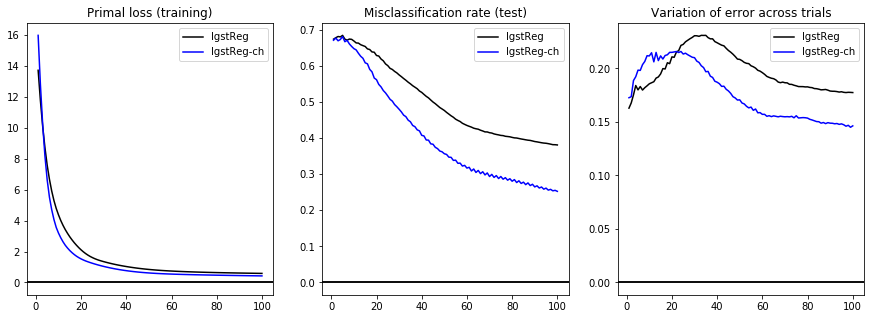

In [18]:
## Visualization of performance.

tvals = np.arange(t_max)+1 # better to start from the first update.

# Average over trials.
myfig = plt.figure(figsize=(15,5))

ax_loss_tr = myfig.add_subplot(1, 3, 1)
for m in m_idx_todo:
    vals = ave_loss_tr[:,m]
    err = sd_loss_tr[:,m]
    ax_loss_tr.plot(tvals, vals, color=mth_colours[m], label=mth_names[m])
    ax_loss_tr.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Primal loss (training)")

ax_riskvals = myfig.add_subplot(1, 3, 2)
for m in m_idx_todo:
    vals = ave_riskvals[:,m]
    err = sd_riskvals[:,m]
    err_log = err / vals
    ax_riskvals.plot(tvals, vals, "-", color=mth_colours[m], label=mth_names[m])
    ax_riskvals.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Misclassification rate (test)")

ax_variation = myfig.add_subplot(1, 3, 3)
for m in m_idx_todo:
    vals = sd_riskvals[:,m]
    ax_variation.plot(tvals, vals, "-", color=mth_colours[m], label=mth_names[m])
    ax_variation.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Variation of error across trials")


plt.show()

In [19]:
# Close the file connection.
f.close()

__Exercises:__

0. Note that while the behaviour is very similar, "lgstReg" and "lgstReg-ch" clearly do *not* perform identically. Why is this?

<a id="chainer_newopt"></a>
### Doing optimization by hand

The above examples made use of the built-in SGD `Optimizer` object which implements "vanilla SGD" in Chainer, namely the sub-class `SGD`, although we only used it for full-batch updates, and thus it was deterministic.

If we want a bit more control over the optimization procedure that we use, there are two options: (1) making custom `Optimizer` sub-classes, and (2) working directly with `Parameter`s to be controlled, outside the `Optimizer` framework. The former makes it very easy to utilize CPU/GPU hardware explicitly, but lacks flexibility. With the latter, we can basically do anything we want.

#### Simple example: GD by hand.

In [20]:
## Experiment setup.

# Data-related.
data = dataclass.DataSet() # Initialize one data object; will be re-populated at each trial.
n = 500 # sample size
d = 2 # number of parameters
init_delta = 5.0 # controls support of random initialization
num_trials = 250 # number of independent random trials to conduct
cov_X = np.eye(d) # covariance matrix of the inputs.

w_star = np.ones(d).reshape((d,1)) # vector specifying true model

# Algorithm-related.
m_idx_todo = [0,1] # let's us manually pick and choose which methods to evaluate.
t_max = 30 # termination condition; maximum number of iterations.
thres = -1.0 # termination condition; if negative, runs for max iterations.

def alpha_fixed(t, val): # step-size callback function.
    return val
def make_step(u):
    def mystep(t, model=None, data=None, newdir=None):
        return alpha_fixed(t=t, val=u)
    return mystep
alphaval = 0.25

# Clerical.
mth_names = ["gd", "gd-ch"]
num_mths = len(mth_names)
mth_colours = ["black", "blue"]

In [21]:
# Make choice of additive noise distribution (un-comment your choice).
#paras = {"name": "norm", "shift": 0.0, "scale": 20.0}
paras = {"name": "lnorm", "meanlog": 0.0, "sdlog": 1.75}

# Put together risk function.
def risk(w):
    mean_noise, var_noise = hlp.noise_risk(paras=paras)
    return hlp.riskMaker(w=w, A=cov_X, b=math.sqrt(var_noise), w_star=w_star)
risk_star = risk(w=w_star) # optimal risk value.

In [23]:
## Running the algorithms.

# Prepare storage for performance metrics.
riskvals = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
loss_tr = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
truedist = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)

# Loop over trials.
for tri in range(num_trials):
    
    # Generate new data (with *centered* noise).
    X = np.random.normal(loc=0.0, scale=1.0, size=(n,d))
    noise = hlp.noise_data(n=n, paras=paras)
    y = np.dot(X, w_star) + noise
    data.init_tr(X=X, y=y)
    
    # Data for Chainer model.
    Z = ch.datasets.TupleDataset(np.float32(X),
                                 np.float32(y))
    
    # Initial weight settings.
    w_init = w_star + np.random.uniform(low=-init_delta, high=init_delta, size=d).reshape((d,1))
    w_init = np.float32(w_init)
    
    # Initialize models (hand-built).
    mod_learner = models.LinearL2(data=data)
    risk_star = risk(w=w_star) # optimal risk value.
    loss_star = np.mean(mod_learner.l_tr(w=w_star, data=data))
    
    # Initialize models (Chainer-based).
    mod_chainer = Chain_LinReg(out_l0=d,
                          out_l1=1,
                          init_W=w_init.T,
                          init_b=None,
                          init_delta=init_delta,
                          nobias=True)
    
    # Initialize algorithms (hand-built).
    al_gd = algorithms.Algo_GD(w_init=w_init,
                               step=make_step(alphaval),
                               t_max=t_max,
                               thres=thres,
                               store=True,
                               lamreg=None)

    
    # Run all algorithms and save their performance.
    
    ## ERM-GD.
    mthidx = 0
    if mthidx in m_idx_todo:        
        idx = 0
        for onestep in al_gd:
            al_gd.update(model=mod_learner, data=data)
            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod_learner.l_tr(w=al_gd.w, data=data))-loss_star
            riskvals[tri,idx,mthidx] = risk(w=al_gd.w)-risk_star
            truedist[tri,idx,mthidx] = np.linalg.norm(w_star-al_gd.w)-0
            idx += 1
        
        
    ## Replication of ERM using Chainer.
    mthidx = 1
    if mthidx in m_idx_todo:
        idx = 0
        iter_train = ch.iterators.SerialIterator(dataset=Z,
                                                 batch_size=n, # thus SGD=GD; deterministic.
                                                 repeat=True,
                                                 shuffle=False)
        while iter_train.epoch < t_max:

            # Get our mini-batch.
            Z_batch = iter_train.next()
            X_batch, y_batch = ch.dataset.concat_examples(Z_batch)

            # Predictions.
            prediction_tr = mod_chainer(X_batch)

            # Loss computations (will feed the grad computations).
            loss = ch.functions.mean_squared_error(prediction_tr, y_batch) / 2.0
            loss_star = np.mean(mod_learner.l_tr(w=w_star, data=data))
            
            # Gradient computations.
            mod_chainer.cleargrads()
            loss.backward()

            # Parameter updates.
            for p in mod_chainer.params():
                grad = p.grad
                if grad is None:
                    continue
                else:
                    p.data -= alphaval * grad
            
            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod_learner.l_tr(w=mod_chainer.l1.W.data.T, data=data))-loss_star
            riskvals[tri,idx,mthidx] = risk(w=mod_chainer.l1.W.data.T)-risk_star
            truedist[tri,idx,mthidx] = np.linalg.norm(w_star-mod_chainer.l1.W.data.T)-0
            idx += 1


# Finally, take statistics of the performance metrics over all trials.
ave_loss_tr = np.mean(loss_tr, axis=0)
ave_riskvals = np.mean(riskvals, axis=0)
ave_truedist = np.mean(truedist, axis=0)
sd_loss_tr = np.std(loss_tr, axis=0)
sd_riskvals = np.std(riskvals, axis=0)
sd_truedist = np.std(truedist, axis=0)

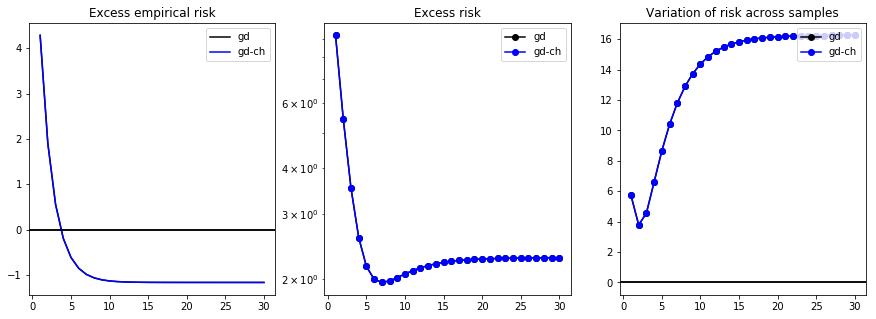

In [24]:
## Visualization of performance.

tvals = np.arange(t_max)+1 # better to start from the first update.

# Average over trials.
myfig = plt.figure(figsize=(15,5))

ax_loss_tr = myfig.add_subplot(1, 3, 1)
for m in m_idx_todo:
    vals = ave_loss_tr[:,m]
    err = sd_loss_tr[:,m]
    ax_loss_tr.plot(tvals, vals, color=mth_colours[m], label=mth_names[m])
    #ax_loss_tr.errorbar(tvals, vals, yerr=err, fmt='-o', col=mth_colours[m], label=mth_names[m])
    ax_loss_tr.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Excess empirical risk")
    

ax_riskvals = myfig.add_subplot(1, 3, 2)
for m in m_idx_todo:
    vals = ave_riskvals[:,m]
    err = sd_riskvals[:,m]
    err_log = err / vals
    ax_riskvals.semilogy(tvals, vals, "-o", color=mth_colours[m], label=mth_names[m])
    ax_riskvals.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Excess risk")

ax_variation = myfig.add_subplot(1, 3, 3)
for m in m_idx_todo:
    vals = sd_riskvals[:,m]
    ax_variation.plot(tvals, vals, "-o", color=mth_colours[m], label=mth_names[m])
    ax_variation.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Variation of risk across samples")


plt.show()

__Exercises:__

0. Modify the hand-built GD optimizer above to be genuine SGD with mini-batch size less than $n$, that iterates precisely $T$ times (be careful of `iter_train.epoch`).

___